In [1]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from adversarial_dataset import AdversarialDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import numpy as np

In [2]:
class TensorToDevice(object):
    def __init__(self, device):
        self.device = device

    def __call__(self, image):
        image = image.to(self.device)
        return image

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

noise_transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
dataset = AdversarialDataset(annotation_file="images.csv",
                             categories_file="categories.csv",
                             img_dir="images",
                             noise_dir="adversarial_noise_targeted",
                             img_transform=transform,
                             noise_transform=None)

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model_to_train = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model_to_train = model_to_train.to(device)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_to_train.parameters(), lr=0.001)

In [6]:
def fgsm(inputs, labels, model, epsilon):
    inputs.requires_grad = True
    output = model(inputs)
    loss = F.nll_loss(output, labels)

    model.zero_grad()
    loss.backward()
    return epsilon*inputs.grad.data.sign()

Epoch: 1/1
Evaluating...


  0%|          | 0/7 [00:00<?, ?it/s]

Train accuracy: 0.0. Test accuracy: 0.88
Train loss: 0.0. Test loss: 0.79
CW accuracy: 0.88. cw target accuracy: 0.0
-------------------------------------------------


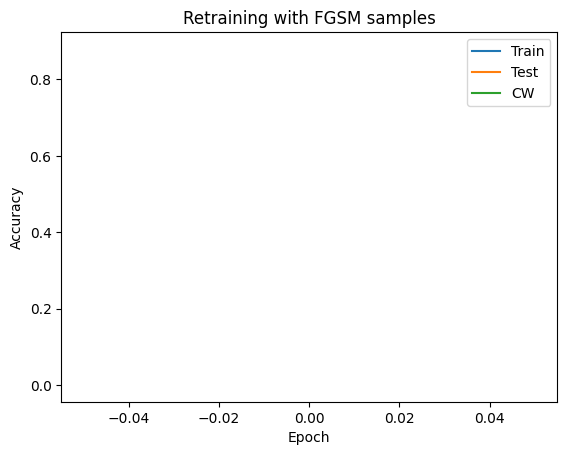

In [11]:
train, test = train_test_split(np.arange(1000), shuffle=True, test_size=.2)

train_split = Subset(dataset, train)
test_split = Subset(dataset, test)

train_loader = DataLoader(train_split, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_split, batch_size=32, pin_memory=True)

n_epochs = 1
model.eval()
model_to_train.train()
epsilon = .1

train_loss_history, test_loss_history = [], []
train_accuracy_history, test_accuracy_history = [], []

cw_accuracy_history, cw_target_accuracy_history = [], []

for i in range(n_epochs):
    print(f"Epoch: {i + 1}/{n_epochs}")
    model_to_train.train()
    
    running_loss_train, running_loss_test = 0.0, 0.0
    running_corrects_train, running_corrects_test = 0, 0
    
    running_corrects_test_cw, running_correct_test_cw_targets = 0, 0
    # print("Training...")
    # for inputs, _, labels, _, id in tqdm(train_loader):
    #     inputs, labels = inputs.to(device), labels.to(device)
    # 
    #     noise = fgsm(inputs, labels, model, .1)
    #     adversarial_image = inputs + noise
    #     assert adversarial_image.shape == inputs.shape
    # 
    #     output, _ = model_to_train(adversarial_image)
    #     train_loss = loss_function(output, labels)
    # 
    #     optimizer.zero_grad()
    #     train_loss.backward()
    #     optimizer.step()
    # 
    #     _, preds = torch.max(output, dim=1)
    # 
    #     running_loss_train += train_loss.item() * inputs.size(0)
    #     running_corrects_train += torch.sum(preds == labels).cpu().item()
        
    model_to_train.eval()
    print("Evaluating...")
    for inputs, cw_noise, labels, targets, id in tqdm(test_loader):
        inputs, labels, targets, cw_noise = inputs.to(device), labels.to(device), targets.to(device), cw_noise.to(device)
        
        fgsm_noise = fgsm(inputs, labels, model, .1)
        fgsm_image = inputs + fgsm_noise
        # cw_image = inputs + cw_noise
        # cw_image = cw_image #.float()
        cw_image = inputs
        assert fgsm_image.shape == inputs.shape
        assert cw_image.shape == inputs.shape
        assert labels.shape == targets.shape
        
        output2 = model_to_train(fgsm_image)
        test_loss = loss_function(output2, labels)
        _, preds = torch.max(output2, dim=1)
        
        cw_output = model_to_train(cw_image)
        _, cw_preds = torch.max(cw_output, dim=1)
        
        running_loss_test += test_loss.item() * inputs.size(0)
        running_corrects_test += torch.sum(preds == labels).cpu().item()
        running_corrects_test_cw += torch.sum(cw_preds == labels).cpu().item()
        running_correct_test_cw_targets += torch.sum(cw_preds == targets).cpu().item()
        
    train_accuracy_history.append(running_corrects_train/len(train_split))
    test_accuracy_history.append(running_corrects_test/len(test_split))
    
    train_loss_history.append(running_loss_train/len(train_split))
    test_loss_history.append(running_loss_test/len(test_split))
    
    cw_accuracy_history.append(running_corrects_test_cw/len(test_split)) 
    cw_target_accuracy_history.append(running_correct_test_cw_targets/len(test_split))
    
    save_path = os.path.join("fgsm_defense_models", f"epoch{i}.pt")
    torch.save(model_to_train.state_dict(), save_path)
    
    
    # plt.plot(train_loss_history, label="Train loss")
    # plt.plot(test_loss_history, label="Test loss")
    plt.figure()
    plt.title('Retraining with FGSM samples')
    plt.plot(train_accuracy_history, label="Train")
    plt.plot(test_accuracy_history, label="Test")
    plt.plot(cw_accuracy_history, label="CW")
    # plt.plot(cw_target_accuracy_history, label="CW target")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig("figures/learning_curve.png")
    
    print(f"Train accuracy: {round(train_accuracy_history[-1], 2)}. Test accuracy: {round(test_accuracy_history[-1], 2)}")
    print(f"Train loss: {round(train_loss_history[-1], 2)}. Test loss: {round(test_loss_history[-1], 2)}")
    print(f"CW accuracy: {round(cw_accuracy_history[-1], 2)}. cw target accuracy: {round(cw_target_accuracy_history[-1], 4)}")
    print("-------------------------------------------------")


In [12]:
cw_accuracy_history[-1]

0.875